In [1]:
%pylab notebook

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

import primo.models
import primo.datasets
import primo.tools.sequences as seqtools

from copy import deepcopy

from primo.models.cas9_keras import log10_crispr_spec, log10_norm_crispr_spec, linear_crispr_spec

from primo.models.encoder import entropy_regularizer

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-_gvuku_j because the default path (/tf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Populating the interactive namespace from numpy and matplotlib
1 Physical GPUs, 1 Logical GPUs


In [2]:
train_dataset = primo.datasets.OpenImagesTrain(
    '/tf/open_images/train/', switch_every=10**5
)
validation_dataset = primo.datasets.OpenImagesVal('/tf/open_images/validation/')

def keras_batch_generator(dataset_batch_generator, similarity_threshold):
    # Yield datasets
    # TODO: Verify with Callie this understanding is correct https://github.com/uwmisl/cas9-similarity-search/issues/2
    while True:
        # This tuple contains:
        # indices: a positive integer uniquely identifying an image. This index is obtained by enumerating all the images in the dataset (before splitting them into test/train/validate datasets)
        # pairs:
        indices, pairs = next(dataset_batch_generator)
        # The Euclidean distances between the two vectors in each pair
        distances = np.sqrt(np.square(pairs[:,0,:] - pairs[:,1,:]).sum(1))
        # Whether or not the images in this pair should be considered 'similar'. This is a boolean value, represented by an int (0 or 1), and is determined by whether the aforementioned Euclidean distances between image feature vectors are under some pre-deterined "similarity threshold".
        similar = (distances < similarity_threshold).astype(int)
        # Yield a pair of sequences, and 0-or-1 indicating whether they're similar.
        yield pairs, similar

# To see how this value was derived, please consult the Materials and Methods subsection under Feature Extraction section.
similarity_threshold = 75
# Intuitively determined:
batch_size = 150
val_batch_size = 150

train_batch_generator = keras_batch_generator(
    train_dataset.balanced_pairs(batch_size, similarity_threshold),
    similarity_threshold
)

val_batch_generator = keras_batch_generator(
    validation_dataset.balanced_pairs(val_batch_size, similarity_threshold),
    similarity_threshold
)
        
train_inputs, train_targets = next(train_batch_generator)

switching to train_e.h5 and train_5.h5


In [3]:
OUTPUT_LEN = 20


encoder = tf.keras.Sequential([
    layers.Dense(4096, activation = 'relu', activity_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dropout(0.5),
    layers.Dense(2048, activation = 'relu', activity_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dropout(0.5),
    layers.Dense(OUTPUT_LEN * 4, activation='relu'),
    layers.Reshape([OUTPUT_LEN, 4]),
    layers.Activation('softmax'),
    layers.Lambda(
        # Just using the identity because we don't want to transform the softmaxxed output,
        # we just want to make sure we learn an output encoding that's regularized (i.e. not crazy complex/over-fitting)
        lambda x: x,

        # In inference mode, this does nothing (just passes identity), but when training, this regularizes
        # the activations.
        # Using an "entropy" regulator because we passed the output through a softmax.
        activity_regularizer=entropy_regularizer(
            0.001
        )
    )

], name='encoder')

#encoder = tf.keras.models.load_model('/tf/primo/data/models/exp_encoder_2.h5')

# from primo.models.encoder import ClusteringLayer
# import pickle
# with open('/tf/primo/data/clusters_kmeans_64.pkl', 'rb') as f:
#     kmodel = pickle.loads(f.read())
# kmeans = kmodel.cluster_centers_
# encoder = tf.keras.Sequential([
#     ClusteringLayer(kmeans.shape[0], kmeans, input_dim=4096, alpha=25.0),
#     layers.Dense(1024, activation = 'relu'),
#     layers.Dense(OUTPUT_LEN * 4, activation='relu'),
#     layers.Reshape([OUTPUT_LEN, 4]),
#     layers.Activation('softmax'),
# ], name='encoder')

X_pairs = layers.Input([2, 4096])

# Essentially, we started with ]a batch of feature-vector pairs...
# ...And turned them into a pair of feature-vector batches.
X1, X2 = layers.Lambda(lambda X: (X[:,0,:], X[:,1,:]))(X_pairs)

distances = layers.Lambda(lambda Xs: tf.sqrt(tf.reduce_sum(tf.square(Xs[0]-Xs[1]), axis=1)))([X1,X2])

# Independently transforms the batches of feature vectors into soft-max encoded DNA sequences.
S1 = encoder(X1)
S2 = encoder(X2)

# Glue them back together! Back into a batch of feature vector pairs.
S_pairs = layers.Lambda(
    lambda Ss: tf.stack(Ss, axis=-1)
)([S1,S2])

# Dimensions: (batch_size x 80 x 4 x 2 ) (i.e. batch size x DNA length x # of nucleotides x 2)

# Swaps dimensions for the predictor, which wants (batch-size x 2 x DNA length x 4)
S_pairs_T = layers.Lambda(lambda S: tf.transpose(S, [0, 3, 1, 2]))(S_pairs)

# y_h: Estimated output
y_h = layers.Lambda(tf.function(linear_crispr_spec(-1.3)))(S_pairs_T)
y_h_T = layers.Reshape([1])(y_h)
    
calcseq = tf.keras.Model(inputs=X_pairs, outputs=S_pairs_T)
calcdists = tf.keras.Model(inputs=X_pairs, outputs=distances)
encoder_trainer = tf.keras.Model(inputs=X_pairs, outputs=y_h_T)

print(encoder.summary())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              16781312  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                163920    
_________________________________________________________________
reshape (Reshape)            (None, 20, 4)             0         
_________________________________________________________________
activation (Activation)      (None, 20, 4)             0   

In [6]:
def UniquenessMetric(y_true, y_pred):
    """Use a single batch of inputs to measure sequence uniqueness while training"""
    seqs = calcseq(train_inputs)
    # Reduce seqs to a single base (e.g. [0.6, 0.2, 0.1, 0.1] -> [0])
    rounded_seqs = K.argmax(seqs[:, 0, :, :], axis=-1)
    # Now each sample is array of 20 integers, 0-3. Multiply each position by 4**n to make
    # a unique integer for each possible 20bp sequence
    hashed_seqs = tf.reduce_sum(rounded_seqs * (4 ** tf.range(0, 20, dtype=tf.int64)), axis=-1)
    # Get unique ones
    unique_seqs, _ = tf.unique(hashed_seqs)
    # Return ratio of unique to input
    return float(len(unique_seqs)) / len(train_inputs)

def ConfidenceMetric(batch):
    """Uses a single batch of inputs to measure sequence uniqueness while training"""
    def f(_y_true, _y_pred):
        seqs = calcseq(train_inputs)
        # Get the highest probabilty value for each base
        max_seqs = tf.reduce_max(seqs, axis=-1)
        # Take mean along both batch and seqence dimensions
        return tf.reduce_mean(max_seqs)

In [7]:
encoder_trainer.compile(
    tf.keras.optimizers.Adagrad(1e-3, clipnorm=1.0),
    'binary_crossentropy',
    run_eagerly=False,
    metrics=[UniquenessMetric, 'accuracy'])
history = encoder_trainer.fit(
    train_batch_generator,
    validation_data=val_batch_generator,
    validation_steps=5,
    steps_per_epoch=500,
    epochs=300)

Epoch 1/300
500/500 [==============================] - 29s 55ms/step - loss: 2.0402 - UniquenessMetric: 0.4158 - accuracy: 0.5229 - val_loss: 1.4185 - val_UniquenessMetric: 0.3800 - val_accuracy: 0.5573
Epoch 2/300
500/500 [==============================] - 27s 54ms/step - loss: 1.2782 - UniquenessMetric: 0.4209 - accuracy: 0.6321 - val_loss: 1.2150 - val_UniquenessMetric: 0.4200 - val_accuracy: 0.6173
Epoch 3/300
500/500 [==============================] - 26s 53ms/step - loss: 1.1267 - UniquenessMetric: 0.3818 - accuracy: 0.6608 - val_loss: 1.0818 - val_UniquenessMetric: 0.3933 - val_accuracy: 0.6400
Epoch 4/300
500/500 [==============================] - 26s 52ms/step - loss: 1.0288 - UniquenessMetric: 0.3824 - accuracy: 0.6826 - val_loss: 1.0154 - val_UniquenessMetric: 0.3867 - val_accuracy: 0.6467
Epoch 5/300
500/500 [==============================] - 26s 52ms/step - loss: 0.9587 - UniquenessMetric: 0.3827 - accuracy: 0.6965 - val_loss: 0.9634 - val_UniquenessMetric: 0.3933 - val_ac

500/500 [==============================] - 26s 51ms/step - loss: 0.5807 - UniquenessMetric: 0.4344 - accuracy: 0.7870 - val_loss: 0.7312 - val_UniquenessMetric: 0.4467 - val_accuracy: 0.6907
Epoch 41/300
500/500 [==============================] - 26s 51ms/step - loss: 0.5666 - UniquenessMetric: 0.4626 - accuracy: 0.7895 - val_loss: 0.7429 - val_UniquenessMetric: 0.4600 - val_accuracy: 0.7120
Epoch 42/300
500/500 [==============================] - 38s 76ms/step - loss: 0.5691 - UniquenessMetric: 0.4621 - accuracy: 0.7893 - val_loss: 0.8005 - val_UniquenessMetric: 0.4467 - val_accuracy: 0.6787
Epoch 43/300
500/500 [==============================] - 26s 52ms/step - loss: 0.5702 - UniquenessMetric: 0.4607 - accuracy: 0.7902 - val_loss: 0.7738 - val_UniquenessMetric: 0.4733 - val_accuracy: 0.7000
Epoch 44/300
500/500 [==============================] - 26s 51ms/step - loss: 0.5719 - UniquenessMetric: 0.4614 - accuracy: 0.7882 - val_loss: 0.7179 - val_UniquenessMetric: 0.4800 - val_accuracy: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 26s 51ms/step - loss: 0.4943 - UniquenessMetric: 0.4659 - accuracy: 0.8106 - val_loss: 0.6221 - val_UniquenessMetric: 0.4667 - val_accuracy: 0.7387
Epoch 89/300
500/500 [==============================] - 25s 51ms/step - loss: 0.4960 - UniquenessMetric: 0.4657 - accuracy: 0.8101 - val_loss: 0.6019 - val_UniquenessMetric: 0.4533 - val_accuracy: 0.7440
Epoch 90/300
500/500 [==============================] - 25s 51ms/step - loss: 0.4903 - UniquenessMetric: 0.4369 - accuracy: 0.8139 - val_loss: 0.5813 - val_UniquenessMetric: 0.4400 - val_accuracy: 0.7440
Epoch 91/300
500/500 [==============================] - 25s 51ms/step - loss: 0.4932 - UniquenessMetric: 0.4396 - accuracy: 0.8123 - val_loss: 0.5927 - val_UniquenessMetric: 0.4400 - val_accuracy: 0.7640
Epoch 92/300
500/500 [==============================] - 25s 51ms/step - loss: 0.4997 - UniquenessMetric: 0.4376 - accuracy: 0.8093 - val_loss: 0.6063 - val_UniquenessMetric: 0.4333 - val_accuracy: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 24s 49ms/step - loss: 0.4785 - UniquenessMetric: 0.4577 - accuracy: 0.8187 - val_loss: 0.5929 - val_UniquenessMetric: 0.4533 - val_accuracy: 0.7520
Epoch 115/300
500/500 [==============================] - 25s 49ms/step - loss: 0.4760 - UniquenessMetric: 0.4445 - accuracy: 0.8211 - val_loss: 0.6062 - val_UniquenessMetric: 0.4600 - val_accuracy: 0.7440
Epoch 116/300
500/500 [==============================] - 25s 49ms/step - loss: 0.4761 - UniquenessMetric: 0.4510 - accuracy: 0.8191 - val_loss: 0.5455 - val_UniquenessMetric: 0.4400 - val_accuracy: 0.7573
Epoch 117/300
500/500 [==============================] - 25s 49ms/step - loss: 0.4732 - UniquenessMetric: 0.4551 - accuracy: 0.8214 - val_loss: 0.5662 - val_UniquenessMetric: 0.4467 - val_accuracy: 0.7640
Epoch 118/300
500/500 [==============================] - 25s 49ms/step - loss: 0.4745 - UniquenessMetric: 0.4440 - accuracy: 0.8216 - val_loss: 0.6083 - val_UniquenessMetric: 0.4067 - val_accura

500/500 [==============================] - 26s 51ms/step - loss: 0.4518 - UniquenessMetric: 0.4299 - accuracy: 0.8320 - val_loss: 0.5822 - val_UniquenessMetric: 0.4333 - val_accuracy: 0.7787
Epoch 153/300
500/500 [==============================] - 26s 51ms/step - loss: 0.4521 - UniquenessMetric: 0.4347 - accuracy: 0.8300 - val_loss: 0.5311 - val_UniquenessMetric: 0.4467 - val_accuracy: 0.7773
Epoch 154/300
500/500 [==============================] - 25s 51ms/step - loss: 0.4587 - UniquenessMetric: 0.4466 - accuracy: 0.8282 - val_loss: 0.5291 - val_UniquenessMetric: 0.4467 - val_accuracy: 0.7587
Epoch 155/300
500/500 [==============================] - 26s 52ms/step - loss: 0.4523 - UniquenessMetric: 0.4489 - accuracy: 0.8308 - val_loss: 0.5786 - val_UniquenessMetric: 0.4400 - val_accuracy: 0.7413
Epoch 156/300
500/500 [==============================] - 26s 51ms/step - loss: 0.4486 - UniquenessMetric: 0.4503 - accuracy: 0.8295 - val_loss: 0.5740 - val_UniquenessMetric: 0.4533 - val_accura

500/500 [==============================] - 35s 71ms/step - loss: 0.4483 - UniquenessMetric: 0.4671 - accuracy: 0.8301 - val_loss: 0.5397 - val_UniquenessMetric: 0.4733 - val_accuracy: 0.7667
Epoch 191/300
500/500 [==============================] - 25s 51ms/step - loss: 0.4469 - UniquenessMetric: 0.4665 - accuracy: 0.8311 - val_loss: 0.5466 - val_UniquenessMetric: 0.4600 - val_accuracy: 0.7733
Epoch 192/300
500/500 [==============================] - 26s 52ms/step - loss: 0.4467 - UniquenessMetric: 0.4695 - accuracy: 0.8321 - val_loss: 0.5528 - val_UniquenessMetric: 0.4600 - val_accuracy: 0.7813
Epoch 193/300
500/500 [==============================] - 26s 52ms/step - loss: 0.4436 - UniquenessMetric: 0.4628 - accuracy: 0.8326 - val_loss: 0.5513 - val_UniquenessMetric: 0.4800 - val_accuracy: 0.7533
Epoch 194/300
500/500 [==============================] - 26s 52ms/step - loss: 0.4456 - UniquenessMetric: 0.4656 - accuracy: 0.8308 - val_loss: 0.4854 - val_UniquenessMetric: 0.4800 - val_accura

500/500 [==============================] - 89s 179ms/step - loss: 0.4356 - UniquenessMetric: 0.4577 - accuracy: 0.8371 - val_loss: 0.5217 - val_UniquenessMetric: 0.4667 - val_accuracy: 0.7800
Epoch 230/300
500/500 [==============================] - 26s 51ms/step - loss: 0.4342 - UniquenessMetric: 0.4600 - accuracy: 0.8397 - val_loss: 0.4931 - val_UniquenessMetric: 0.4600 - val_accuracy: 0.8040
Epoch 231/300
500/500 [==============================] - 26s 52ms/step - loss: 0.4313 - UniquenessMetric: 0.4654 - accuracy: 0.8371 - val_loss: 0.4852 - val_UniquenessMetric: 0.4733 - val_accuracy: 0.7840
Epoch 232/300
500/500 [==============================] - 26s 51ms/step - loss: 0.4328 - UniquenessMetric: 0.4714 - accuracy: 0.8379 - val_loss: 0.5419 - val_UniquenessMetric: 0.4667 - val_accuracy: 0.7680
Epoch 233/300
500/500 [==============================] - 26s 52ms/step - loss: 0.4341 - UniquenessMetric: 0.4724 - accuracy: 0.8382 - val_loss: 0.5522 - val_UniquenessMetric: 0.4667 - val_accur

500/500 [==============================] - 26s 52ms/step - loss: 0.4239 - UniquenessMetric: 0.4592 - accuracy: 0.8446 - val_loss: 0.5557 - val_UniquenessMetric: 0.4533 - val_accuracy: 0.7480
Epoch 268/300
500/500 [==============================] - 26s 52ms/step - loss: 0.4260 - UniquenessMetric: 0.4674 - accuracy: 0.8433 - val_loss: 0.5316 - val_UniquenessMetric: 0.4667 - val_accuracy: 0.7707
Epoch 269/300
500/500 [==============================] - 27s 54ms/step - loss: 0.4272 - UniquenessMetric: 0.4638 - accuracy: 0.8452 - val_loss: 0.5506 - val_UniquenessMetric: 0.4667 - val_accuracy: 0.7547
Epoch 270/300
500/500 [==============================] - 26s 52ms/step - loss: 0.4225 - UniquenessMetric: 0.4693 - accuracy: 0.8451 - val_loss: 0.5458 - val_UniquenessMetric: 0.4733 - val_accuracy: 0.7973
Epoch 271/300
500/500 [==============================] - 49s 99ms/step - loss: 0.4275 - UniquenessMetric: 0.4752 - accuracy: 0.8416 - val_loss: 0.5200 - val_UniquenessMetric: 0.4800 - val_accura

In [69]:
# encoder_trainer.compile(tf.keras.optimizers.Adagrad(1e-3), 'binary_crossentropy')
# history = encoder_trainer.fit(train_inputs, train_targets, epochs=300)

Epoch 1/300
5/5 [==============================] - 1s 6ms/step - loss: 0.3995
Epoch 2/300
5/5 [==============================] - 0s 6ms/step - loss: 0.3674
Epoch 3/300
5/5 [==============================] - 0s 6ms/step - loss: 0.3324
Epoch 4/300
5/5 [==============================] - 0s 6ms/step - loss: 0.3331
Epoch 5/300
5/5 [==============================] - 0s 6ms/step - loss: 0.3012
Epoch 6/300
5/5 [==============================] - 0s 6ms/step - loss: 0.2716
Epoch 7/300
5/5 [==============================] - 0s 6ms/step - loss: 0.2538
Epoch 8/300
5/5 [==============================] - 0s 6ms/step - loss: 0.2638
Epoch 9/300
5/5 [==============================] - 0s 6ms/step - loss: 0.2617
Epoch 10/300
5/5 [==============================] - 0s 6ms/step - loss: 0.2436
Epoch 11/300
5/5 [==============================] - 0s 6ms/step - loss: 0.2356
Epoch 12/300
5/5 [==============================] - 0s 6ms/step - loss: 0.2258
Epoch 13/300
5/5 [==============================] - 0s 6ms/st

5/5 [==============================] - 0s 6ms/step - loss: 0.1028
Epoch 105/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1041
Epoch 106/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1007
Epoch 107/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1067
Epoch 108/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1025
Epoch 109/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1123
Epoch 110/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1048
Epoch 111/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1042
Epoch 112/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1028
Epoch 113/300
5/5 [==============================] - 0s 6ms/step - loss: 0.0984
Epoch 114/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1030
Epoch 115/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1051
Epoch 116/300
5/5 [==============================] - 0

KeyboardInterrupt: 

In [80]:

encoder.save('/tf/primo/data/models/exp_encoder_x.h5')

<IPython.core.display.Javascript object>


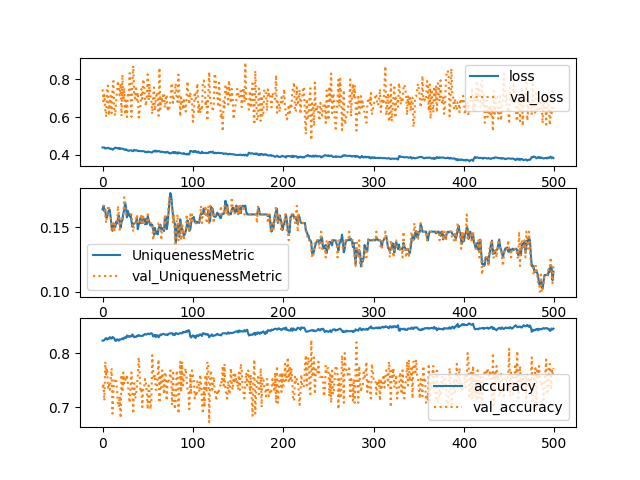

In [87]:
fig = plt.figure()
lines = [k for k in history.history.keys() if not k.startswith('val_')]

axes = fig.subplots(len(lines), 1)
for i in range(len(lines)):
    label = lines[i]
    ax = axes[i]
    val_label = 'val_' + label

    ax.plot(history.history[label], label=label)
    ax.plot(history.history[val_label], linestyle=':', label=val_label)
    ax.legend()

    

<IPython.core.display.Javascript object>


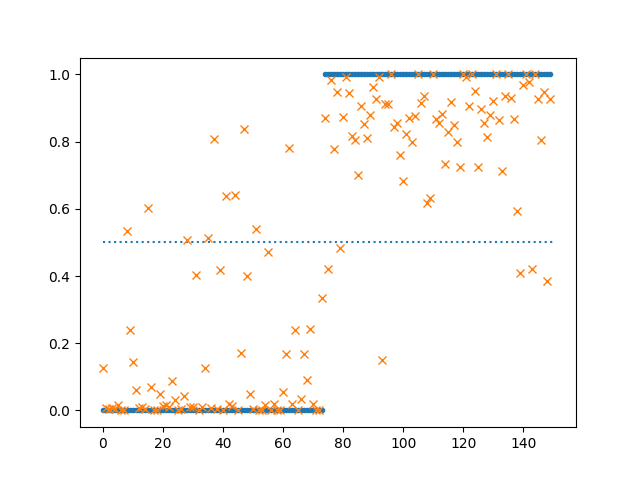

(150,)
(150,)


In [156]:
idx = train_targets.argsort()

Y = encoder_trainer.predict(train_inputs)
seqs = calcseq.predict(train_inputs)
plt.figure()

print(train_targets.shape)
print((Y[:, 0] - train_targets).shape)
plt.plot(train_targets[idx], '.')
plt.plot(Y[idx][:, 0], 'x')
plt.hlines(0.5, 0, len(seqs), linestyle=':')

<IPython.core.display.Javascript object>


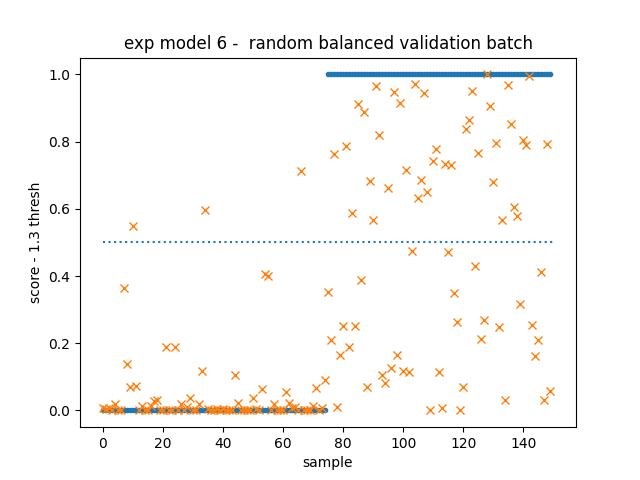

(150,)
(150,)


Text(0.5, 1.0, 'exp model 6 -  random balanced validation batch')

In [159]:
def get_batchs(n, generator):
    inputs = None
    target = None
    for _ in range(n):
        i, t = next(generator)
        if inputs is None:
            inputs = i
            targets = t
        else:
            inputs = np.concatenate([inputs, i])
            targets = np.concatenate([targets, t])
    return inputs, targets

#val_inputs, val_targets = next(val_batch_generator)
val_inputs, val_targets = get_batchs(3, val_batch_generator)

idx = val_targets.argsort()

Y = encoder_trainer.predict(val_inputs)
plt.figure()

print(val_targets.shape)
print((Y[:, 0] - val_targets).shape)
plt.plot(val_targets[idx], '.')
plt.plot(Y[idx][:, 0], 'x')
plt.hlines(0.5, 0, len(Y), linestyle=':')
plt.ylabel('score - 1.3 thresh')
plt.xlabel('sample')
plt.title('exp model 6 -  random balanced validation batch')



In [160]:
seqs = calcseq.predict(train_inputs)
all_seqs = seqs[:, 0, :, :] #np.concatenate([seqs[:, 0, :, :], seqs[:, 1, :, :]])

seq_strings = seqtools.onehots_to_seqs(all_seqs)
print(len(np.unique(all_seqs.argmax(-1), axis=0)))
unique = np.unique(seq_strings)
print(unique)
print(f"{len(unique)} / {len(all_seqs)}")



18
['AACCCAAAAGGTCTCCCAAT' 'AACTAAAAAGGTATCCCAAT' 'AAGCAAAACGGTCTCCCAAT'
 'AAGTAAAAAGGTATCCCAAT' 'AATAAAAAAGGTATCCCAAT' 'ACATAAAAAGGTATCCCAAT'
 'ACCCAAAAAGGTATCCCAAT' 'ACCTAAAAAGGTATCCCAAT' 'ACGTAAAAAGGTATCCCAAT'
 'AGAAAAAAAGGTATCCCAAT' 'AGACCAAACGGTCTCCCAAT' 'AGATAAAAAGGTATCCCAAT'
 'AGCAAAAAAGGTATCCCAAT' 'AGCCAAAAAGGTATCCCAAT' 'AGCTAAAAAGGTATCCCAAT'
 'AGGGCAAACGGTCTCCCAAT' 'AGGTAAAAAGGTATCCCAAT' 'ATTGTAAACGGTCTCCCAAT']
18 / 150


In [146]:
all_seqs[7]

array([[0.2884175 , 0.23601155, 0.23601155, 0.23955944],
       [0.25720426, 0.24759857, 0.24759857, 0.24759857],
       [0.24693605, 0.25148347, 0.2546444 , 0.24693605],
       [0.24139662, 0.24139662, 0.25321403, 0.2639927 ],
       [0.21311817, 0.29027724, 0.281361  , 0.21524361],
       [0.37172765, 0.20942414, 0.20942414, 0.20942414],
       [0.36570013, 0.19783144, 0.20422493, 0.23224354],
       [0.36660382, 0.21478833, 0.20077096, 0.21783693],
       [0.24842957, 0.24842957, 0.24842957, 0.25471133],
       [0.2187479 , 0.226001  , 0.21555598, 0.3396952 ],
       [0.22710787, 0.23759168, 0.24019796, 0.29510248],
       [0.21209948, 0.3627353 , 0.21209948, 0.21306576],
       [0.20428705, 0.2545349 , 0.31877866, 0.22239937],
       [0.21433549, 0.36028582, 0.2119558 , 0.21342291],
       [0.24048308, 0.21929534, 0.32545286, 0.21476874],
       [0.2164845 , 0.20996463, 0.36358628, 0.20996463],
       [0.23047075, 0.23644206, 0.31387344, 0.21921377],
       [0.34276912, 0.23512419,

In [9]:
# weights = [tensor for tensor in encoder_trainer.trainable_weights]# if encoder_trainer.get_layer(tensor.name[:-2]).trainable]
# optimizer = encoder_trainer.optimizer
# loss = tf.keras.metrics.BinaryCrossentropy(from_logits=False)(y_h_T, train_targets)
# g = optimizer.get_gradients(loss, weights)

with tf.GradientTape() as tape:
    # Doing the computation in the context of the gradient tape
    # For example computing loss
    pred = encoder_trainer(train_inputs)
    loss = tf.metrics.MSE(train_targets,pred)
    
# Getting the gradient of weight w.r.t loss 
grad = tape.gradient(loss, encoder_trainer.trainable_weights) 
print(grad)
#print([tf.norm(g).numpy() for g in grad])

[<tf.Tensor: shape=(4096, 2048), dtype=float32, numpy=
array([[-0.00668996, -0.00442752, -0.01292114, ..., -0.00297812,
         0.00866672,  0.00046856],
       [-0.014083  , -0.0085131 , -0.01540488, ..., -0.00662993,
         0.01435623,  0.00218737],
       [-0.00739208, -0.00459306, -0.00793888, ..., -0.00424623,
         0.00936238,  0.00140106],
       ...,
       [-0.00707141, -0.0031601 , -0.00536229, ..., -0.00655378,
         0.01212534,  0.0022773 ],
       [-0.01130053, -0.00968682, -0.01601881, ..., -0.00374336,
         0.00950455,  0.00092499],
       [-0.00697468, -0.0061232 , -0.00847617, ..., -0.0014009 ,
         0.00568788,  0.00132537]], dtype=float32)>, <tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([-0.01711289, -0.01263236, -0.01965856, ..., -0.00607363,
        0.01729374,  0.0022029 ], dtype=float32)>, <tf.Tensor: shape=(2048, 2048), dtype=float32, numpy=
array([[ 5.5676320e-04,  7.4185044e-02,  7.9013333e-02, ...,
        -1.9020287e-02, -2.8113823e-

In [10]:
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

<IPython.core.display.Javascript object>

In [11]:
sample_input = train_inputs[0]
inspect_layers = [encoder.model.layers[0].output, encoder.model.layers[3].output]
layers_model = tf.keras.Model(inputs=encoder.model.input, outputs=inspect_layers)
Y = layers_model.predict(sample_input)
print(Y)
plt.figure()
plt.plot(Y[0].T, '.')

AttributeError: 'Sequential' object has no attribute 'model'

In [ ]:
sim = primo.models.Simulator()
from primo.models.cas9 import crispr_specificity
crispr_specificity('TATGTAGAAAACTGCAAAAC', 'TATGTAGAAAACTGCAAAAC')

In [ ]:
x = np.array([[all_seqs[0], all_seqs[1]]])
print(x.shape)
print(f"linear: {linear_crispr_spec(tf.convert_to_tensor(x, dtype = tf.float32))}")
print(f"log10norm: {log10_norm_crispr_spec(tf.convert_to_tensor(x, dtype = tf.float32))}")
all_seqs[0].shape

In [ ]:
print(np.around(all_seqs[0], 4))